<a href="https://colab.research.google.com/github/adampotton/Group-3-gotta-catch-em-all-/blob/main/Final_model_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from PIL import Image
import random
import os
import csv
import shutil
from google.colab import drive
from sklearn.model_selection import train_test_split
import os
from torchvision.transforms import v2
from torch.optim.lr_scheduler import ReduceLROnPlateau
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
drive.mount('/content/drive')
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


In [ ]:
# DATA LOADING

root_directory = "/content/drive/My Drive/PokemonData"
selected_subdirectory = "/content/drive/My Drive/SelectedPokemonData"

# Get a list of all folders in the PokemonData directory
all_folders = [f for f in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, f))]

# Select random folders
n = 2
selected_folders = random.sample(all_folders, n)
print(selected_folders)

# Remove and recreate selected subdirectory
shutil.rmtree(selected_subdirectory, ignore_errors=True)
os.makedirs(selected_subdirectory, exist_ok=True)

# Copy selected folders to the subdirectory
for folder_name in selected_folders:
    src_folder_path = os.path.join(root_directory, folder_name)
    dest_folder_path = os.path.join(selected_subdirectory, folder_name)
    shutil.copytree(src_folder_path, dest_folder_path)

# Define a common size for resizing images
common_size = (224, 224)

# Dictionary to store image arrays for selected folders
image_arrays_dict = {}

# Iterate over the selected folders in the subdirectory
for folder_name in selected_folders:
    folder_path = os.path.join(selected_subdirectory, folder_name)
    image_arrays = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".png")):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path).convert("RGB").resize(common_size, Image.ANTIALIAS)
            img_array = np.array(img)
            image_arrays.append(img_array)
    image_arrays_dict[folder_name] = np.array(image_arrays)

# Combine all image arrays into a single array
all_images = np.concatenate(list(image_arrays_dict.values()), axis=0)

# Display selected classes and number of images per class
pokemon_classes = list(image_arrays_dict.keys())
num_images_per_class = [len(images) for images in image_arrays_dict.values()]
print(pokemon_classes)
print(num_images_per_class)

['Sandshrew', 'Vulpix']


<ipython-input-3-d232b615dda7>:37: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = Image.open(image_path).convert("RGB").resize(common_size, Image.ANTIALIAS)


['Sandshrew', 'Vulpix']
[118, 126]


In [ ]:
# AUGMENTATION

transform = v2.Compose([
    v2.ToImage(),
    #v2.RandomHorizontalFlip(p=1),
    v2.RandomGrayscale(p=1),
    v2.ToDtype(torch.float32, scale=True)
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

aug_images = []
for img in all_images:
  aug_image = transform(img)
  aug_images.append(aug_image)

aug_images = torch.stack(aug_images)
#combined_images = np.concatenate([all_images, aug_images.permute(0, 2, 3, 1)], axis=0)
combined_images = np.array(aug_images.permute(0, 2, 3, 1))

all_labels = np.concatenate([np.full(num, i) for i, num in enumerate(num_images_per_class)])
combined_labels = np.concatenate([all_labels])


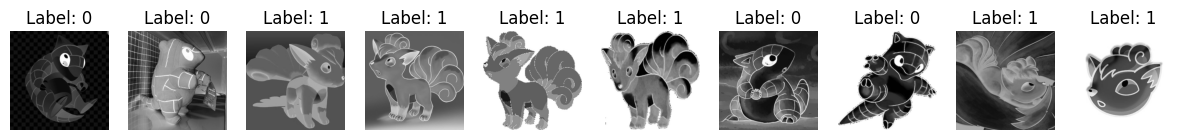

In [ ]:
# SHOWING AUGMENTATION

num_samples = 10  # You can adjust this number as needed
random_indices = random.sample(range(len(combined_images)), num_samples)

# Plot images with labels
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image = combined_images[idx]
    label = combined_labels[idx]
    np_image = (image.squeeze() * 255).astype(np.uint8)
    np_image = 255 - np_image
    axes[i].imshow(np_image)
    axes[i].set_title("Label: {}".format(label))
    axes[i].axis('off')

plt.show()

In [ ]:
# OUR CUSTOM MODEL

# combined_images = all_images
# combined_labels = all_labels

# Split dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=2, stratify=combined_labels
)

# Convert NumPy arrays to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Define the number of classes and input channels
num_classes = n
num_input_channels = 3

# Define the model architecture
model = nn.Sequential(
    nn.Conv2d(num_input_channels, 16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Dropout(0.),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(32 * 56 * 56, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

# Move model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# MOBILENETV2 MODEL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.mobilenet_v2(weights=None)

# Modify the fully connected layer to match the number of classes dataset
num_classes = len(pokemon_classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move the model to the appropriate device
model = model.to(device)

In [ ]:
# LOADING A SAVED MODEL

# Load the saved model weights
saved_model_path = "/content/drive/My Drive/updated_mobilenetv2.pth"
checkpoint = torch.load(saved_model_path)

model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# TRAINING AND TESTING THE MODEL

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Train the model
def train():
    model.train()
    for images, labels in train_loader:
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images.permute(0, 3, 1, 2))

        # Compute the loss
        loss = criterion(logits, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Define testing function
def test(epoch):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images.permute(0, 3, 1, 2))

            # Compute total correct so far
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
        print(f'Test accuracy after {epoch+1} epochs: {100 * correct / total:.2f}%')
        scheduler.step(accuracy)

num_epochs = 20
for epoch in range(num_epochs):
    train()
    test(epoch)

In [ ]:
# SAVING A MODEL

torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': num_classes,
    'class_labels': pokemon_classes,
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}, '/content/drive/My Drive/updated_mobilenetv2.pth')

# for saving the model and checking it exists in dierectory
# mean and std are standard found previously to be best for normalising RGB

files = os.listdir('/content/drive/My Drive')

# Check if the saved model file exists
if 'updated_mobilenetv2.pth' in files:
    print("The model checkpoint file exists in the current directory.")
else:
    print("The model checkpoint file does not exist in the current directory.")
print("New Model saved successfully!")


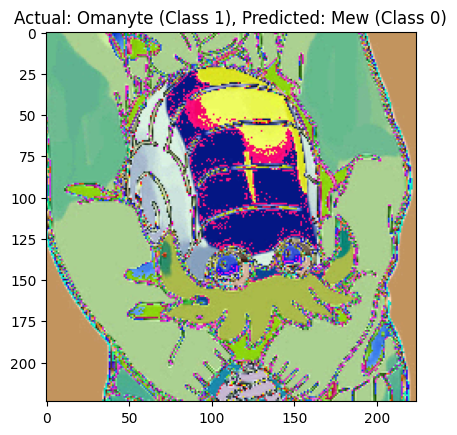

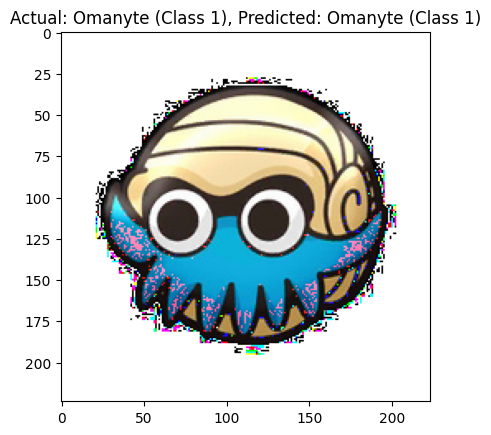

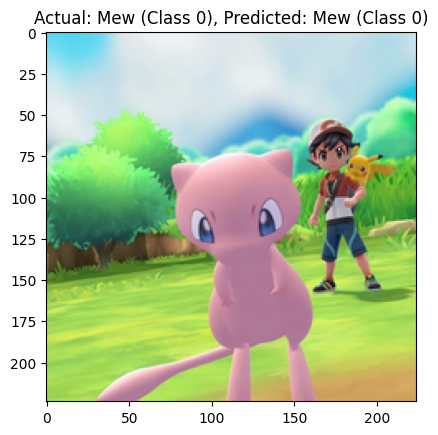

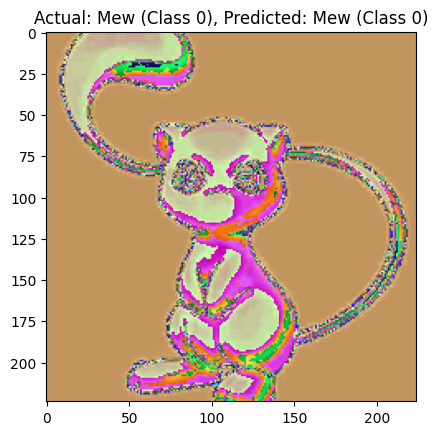

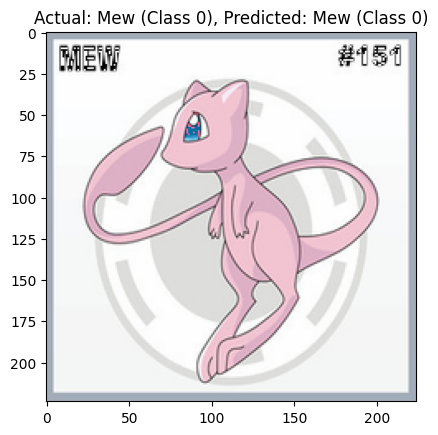

In [ ]:
# SHOWING MODEL PREDICITONS

def display_random_image_prediction(num_runs):
  for i in range(1,num_runs):
    index_to_display = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[index_to_display]
    image = image.unsqueeze(0).to(device)
    logits = model(image.permute(0, 3, 1, 2))
    predicted_label = torch.argmax(logits).item()
    np_image = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
    np_image = 255 - np_image
    plt.imshow(np_image)
    plt.title(f"Actual: {pokemon_classes[label]} (Class {label}), Predicted: {pokemon_classes[predicted_label]} (Class {predicted_label})")
    plt.show()

display_random_image_prediction(3)


<ipython-input-25-1506190fc348>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_resized = image.resize((common_size[1], common_size[0]), Image.ANTIALIAS)


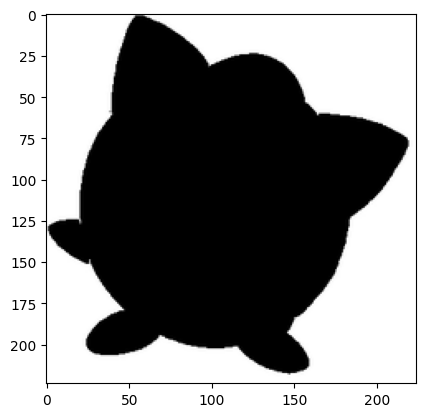

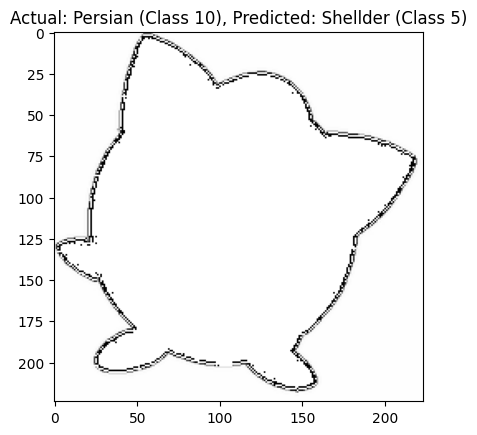

In [ ]:
image_path = '/content/drive/My Drive/Clefairy3.jpg'

image = Image.open(image_path).convert("RGB")  # Convert to RGB format
image_resized = image.resize((common_size[1], common_size[0]), Image.ANTIALIAS)
image_array = np.array(image_resized)
image = torch.tensor(image_array, dtype = torch.float32)
plt.imshow(image_array)
plt.show()
label = 10

image = image.unsqueeze(0).to(device)
logits = model(image.permute(0, 3, 1, 2))
predicted_label = torch.argmax(logits).item()
np_image = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
np_image = 255 - np_image
plt.imshow(np_image)
plt.title(f"Actual: {pokemon_classes[label]} (Class {label}), Predicted: {pokemon_classes[predicted_label]} (Class {predicted_label})")
plt.show()